In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from utils.attacks import fgsm

import matplotlib.pyplot as plt

In [2]:
# Set device
# device = torch.device(
#     "mps" if torch.backends.mps.is_available()
#     else "cuda" if torch.cuda.is_available()
#     else "cpu"
# )
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 test dataset
batch_size  = 1
test_data   = torchvision.datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
iterator    = iter(test_loader)

Files already downloaded and verified


In [4]:
# Load pre-trained ResNet-50 model
model = resnet50()

# Modify the ResNet-50 architecture for CIFAR-10
model.fc = torch.nn.Linear(model.fc.in_features, 10)

# Load pre-trained weights
model.load_state_dict(torch.load("../models/resnet/resnet50_cifar10.pt", map_location=torch.device(device)))  
model.to(device)
model.eval()

# Define CIFAR-10 classes
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

### Generate adversarial sample

In [5]:
class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std  = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return ((tensor * self.std + self.mean) * 255).byte()

# For visualisation, we create a denormalizing transform with the same mean and
# std used in normalization
denormalize = Denormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

Prediction Results:
Image 1:
  Prediction original: ship   (✅ CORRECT)
  Prediction   attack: car   (❌ INCORRECT)
               Actual: ship


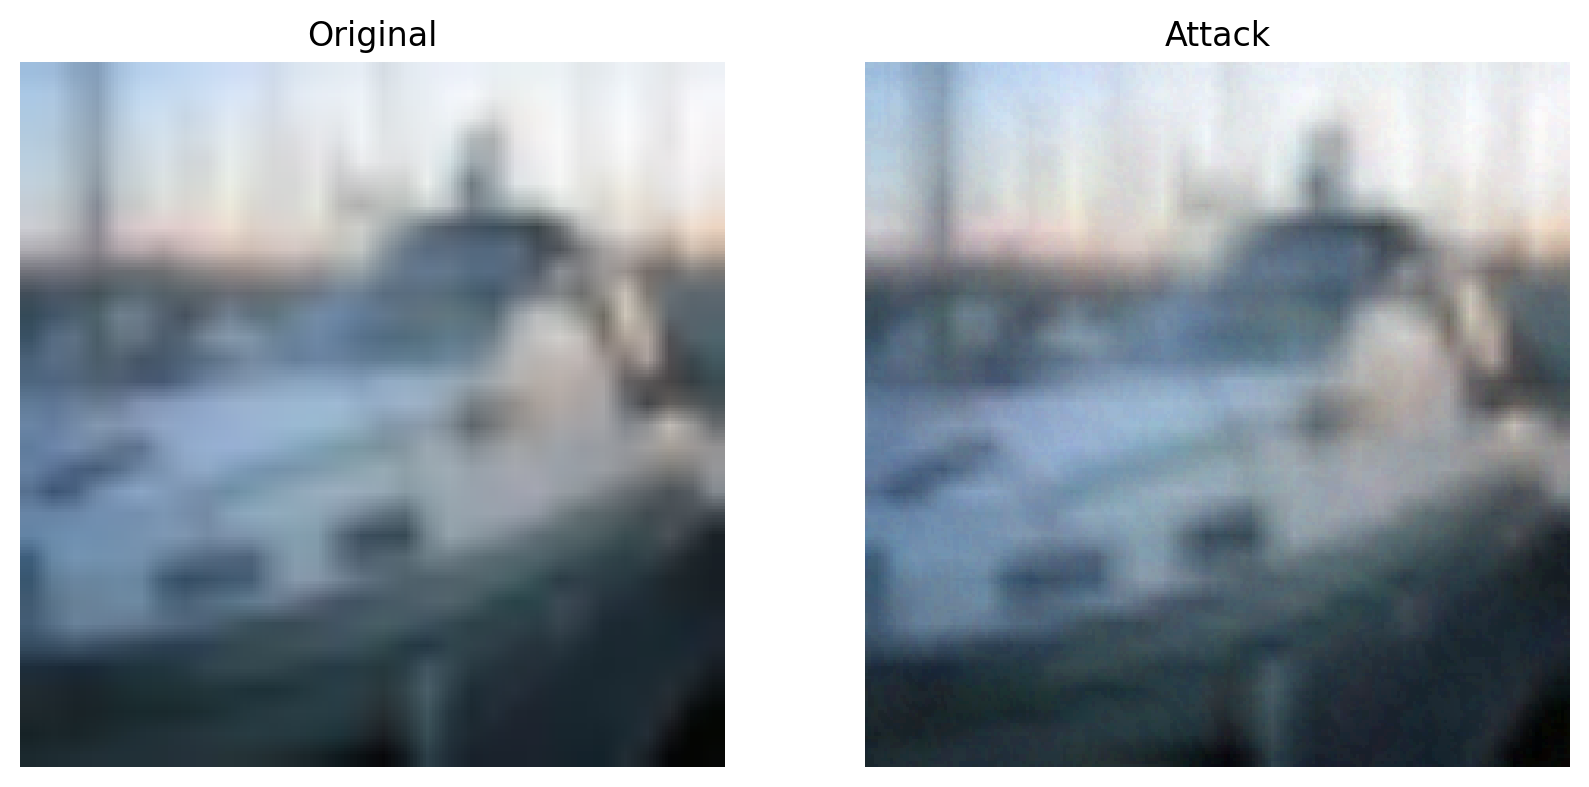

In [8]:
# Get a batch of test images
x_orig, label = next(iterator)
x_adv  = fgsm(model, x=x_orig, label=label, eps=0.05, targeted=False).detach()

# Perform inference
with torch.no_grad():
    x_orig, label = x_orig.to(device), label.to(device)
    pred_orig     = model(x_orig).argmax().item()
    pred_adv      = model(x_adv).argmax().item()

# Print results
print("Prediction Results:")
for i in range(1):
    print(f"Image {i+1}:")
    print(f"  Prediction original: {classes[pred_orig]}   ({'✅ CORRECT' if pred_orig == label else '❌ INCORRECT'})")
    print(f"  Prediction   attack: {classes[pred_adv]}   ({'✅ CORRECT' if pred_adv == label else '❌ INCORRECT'})")
    print(f"               Actual: {classes[label]}")

# Display the selected image and its label
_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
ax[0].imshow(denormalize(x_orig[0]).permute(1, 2, 0), interpolation="nearest")
ax[0].set_title(f"Original")
ax[0].axis("off")

ax[1].imshow(denormalize(x_adv[0]).permute(1, 2, 0), interpolation="nearest")
ax[1].set_title("Attack")
ax[1].axis("off");